# Simulated vs. Measured Cell Sizes

In [1]:
import os
import warnings
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import set_matplotlib_formats
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.stats._stats_mstats_common import LinregressResult
from uncertainties import unumpy as unp

sns.set_style("white")
set_matplotlib_formats("svg", "pdf")

In [2]:
with pd.HDFStore(os.path.join(
    "/home",
    "mick",
    "DetResearch",
    "scripts",
    "simulation_measurement_comparison",
    "simulated_and_measured.h5",
), "r") as store:
    df = store.data

In [3]:
def get_regressions(df_plot: pd.DataFrame, simulation_methods: List[str]) -> Dict[str, LinregressResult]:
    regressions = {}
    for method in simulation_methods:
        regressions[method] = linregress(
            x=df_plot[df_plot["method"] == method]["cell_size"].values,
            y=df_plot[df_plot["method"] == method]["measured"].values,
        )
    
    return regressions


def apply_regressions(row: pd.Series, regressions: Dict[str, LinregressResult]) -> float:
    if row["method"] in regressions.keys():
        regression = regressions[row["method"]]
        result = regression.slope * row["cell_size"] + regression.intercept
    elif row["method"] == "measured":
        result = row["cell_size"]
    else:
        result = np.NaN
    
    return result

In [4]:
df_plot = df.filter(
    items=[
        "diluent",
        "phi_nom",
        "phi",
        "dil_mf_nom",
        "dil_mf",
        "u_cell_size_measured",
        "cell_size_measured",
        "cell_size_gavrikov",
        "cell_size_ng",
        "cell_size_westbrook",
    ]
)
df_plot.columns = [c.replace("cell_size_", "") for c in df_plot.columns]
simulation_methods = ["gavrikov", "ng", "westbrook"]
cell_size_methods = ["measured"] + simulation_methods
df_plot = df_plot.melt(
    id_vars=df_plot.columns.difference(simulation_methods), 
    value_vars=simulation_methods,
    var_name="method",
    value_name="cell_size",
)
df_plot.rename({"u_measured": "u_cell_size"}, axis=1, inplace=True)
regressions = get_regressions(df_plot, simulation_methods)
df_plot["cell_size_corrected"] = df_plot.apply(apply_regressions, axis=1, args=[regressions])

## Grouped by conditions

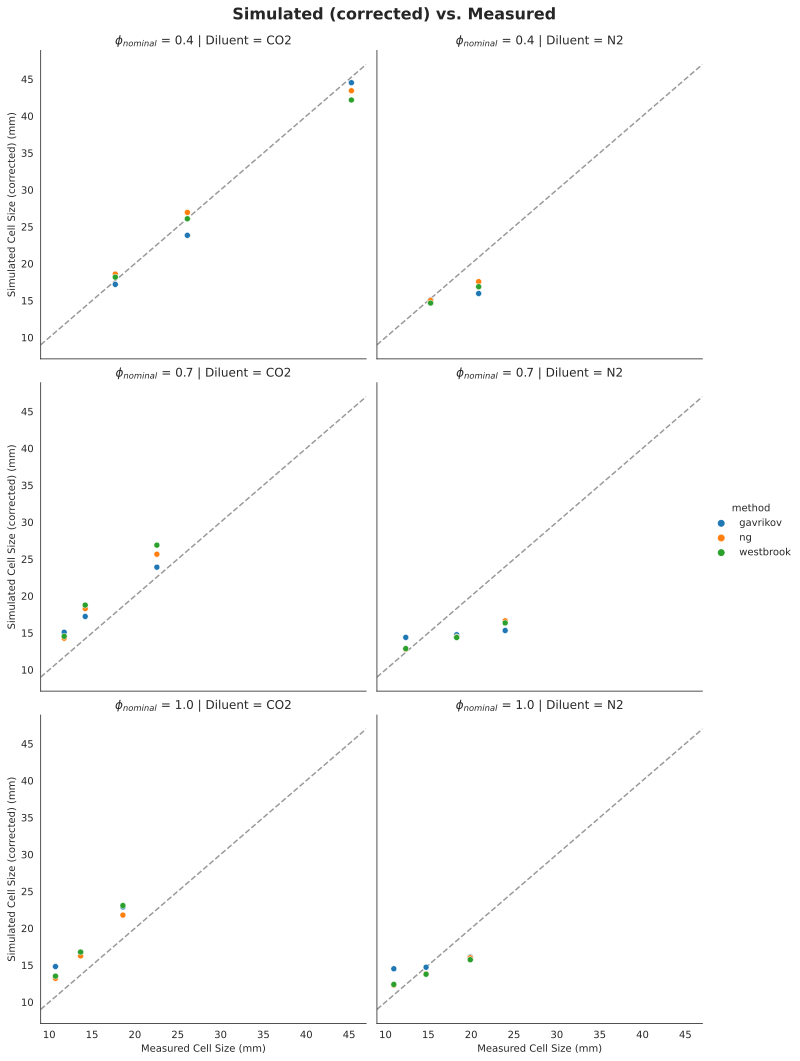

In [5]:
plots = sns.relplot(
    x="measured",
    y="cell_size_corrected",
    hue="method",
    row="phi_nom",
    col="diluent",
    data=df_plot,
)
plots.fig.subplots_adjust(top=0.94)
plots.fig.suptitle("Simulated (corrected) vs. Measured", weight="bold", size=16)
for ax in plots.axes.flatten():
    ax.set_ylabel("Simulated Cell Size (corrected) (mm)")
    if ax.get_xlabel() is not None:
        ax.set_xlabel("Measured Cell Size (mm)")
    ax.set_title(ax.get_title().replace("phi_nom", "$\phi_{nominal}$").replace("diluent", "Diluent"))
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, "k--", alpha=0.4, zorder=-1)
    ax.set_xlim(xlim)

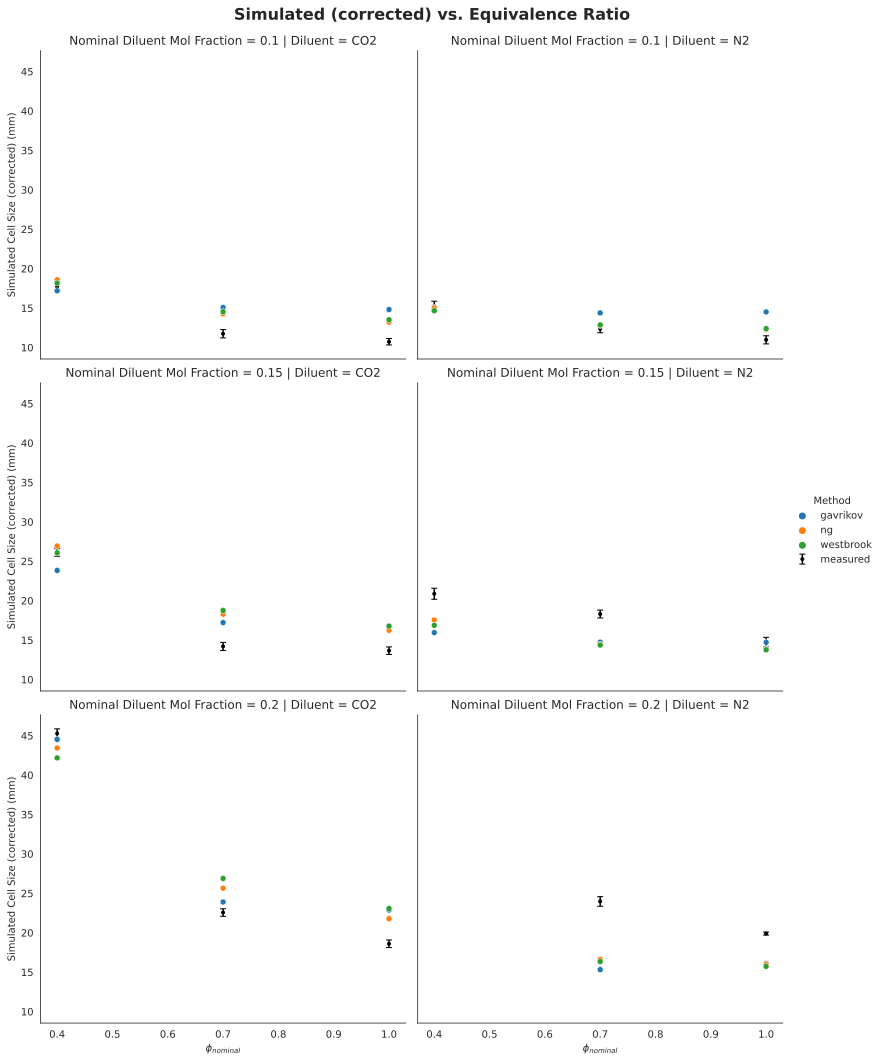

In [6]:
plots = sns.relplot(
    x="phi_nom",
    y="cell_size_corrected",
    hue="method",
    row="dil_mf_nom",
    col="diluent",
    data=df_plot,
)
plots.fig.subplots_adjust(top=0.94)
plots.fig.suptitle("Simulated (corrected) vs. Equivalence Ratio", weight="bold", size=16)
legend_updated = False
for ax in plots.axes.flatten():
    ax.set_ylabel("Simulated Cell Size (corrected) (mm)")
    if ax.get_xlabel() is not None:
        ax.set_xlabel("$\phi_{nominal}$")
    title = ax.get_title()
    parts = title.split(" | ")
    dil_mf_nom = float(parts[0].split(" = ")[1])
    diluent = parts[1].split(" = ")[1]
    sub_df = df[(df["dil_mf_nom"] == dil_mf_nom) & (df["diluent"] == diluent)]
    err = ax.errorbar(
        x=sub_df["phi_nom"], 
        y=sub_df["cell_size_measured"],
        yerr=sub_df["u_cell_size_measured"],
        c="k",
        ls="None",
        zorder=-1,
        capsize=3,
        marker=".",
        label="measured",
    )
    if not legend_updated:
        # add symbol for measured data to the legend
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plots.legend.remove()
            existing_lines, existing_labels = list(ax.get_legend_handles_labels())
            plots.add_legend(handles=existing_lines, labels=existing_labels, title="Method")
            legend_updated = True
    ax.set_title(title.replace("dil_mf_nom", "Nominal Diluent Mol Fraction").replace("diluent", "Diluent"))

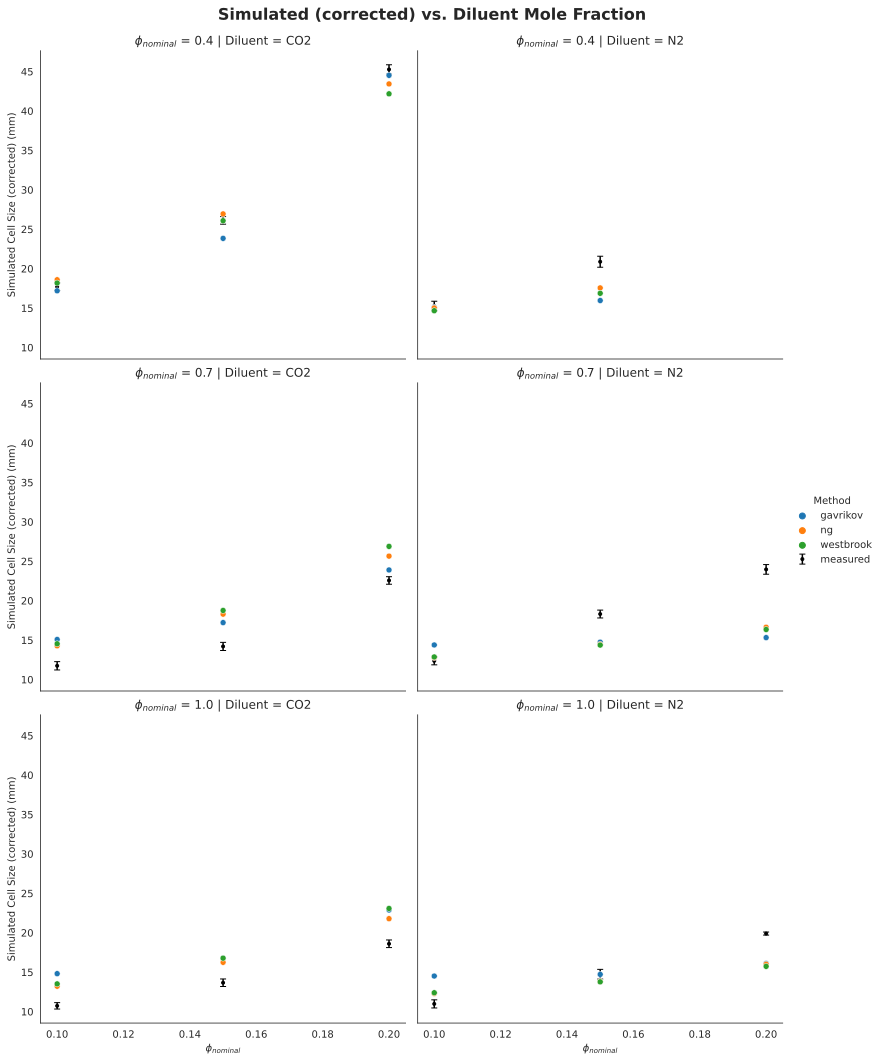

In [7]:
plots = sns.relplot(
    x="dil_mf_nom",
    y="cell_size_corrected",
    hue="method",
    row="phi_nom",
    col="diluent",
    data=df_plot,
)
plots.fig.subplots_adjust(top=0.94)
plots.fig.suptitle("Simulated (corrected) vs. Diluent Mole Fraction", weight="bold", size=16)
legend_updated = False
for ax in plots.axes.flatten():
    ax.set_ylabel("Simulated Cell Size (corrected) (mm)")
    if ax.get_xlabel() is not None:
        ax.set_xlabel("$\phi_{nominal}$")
    title = ax.get_title()
    parts = title.split(" | ")
    phi_nom = float(parts[0].split(" = ")[1])
    diluent = parts[1].split(" = ")[1]
    sub_df = df[(df["phi_nom"] == phi_nom) & (df["diluent"] == diluent)]
    err = ax.errorbar(
        x=sub_df["dil_mf_nom"], 
        y=sub_df["cell_size_measured"],
        yerr=sub_df["u_cell_size_measured"],
        c="k",
        ls="None",
        zorder=-1,
        capsize=3,
        marker=".",
        label="measured",
    )
    if not legend_updated:
        # add symbol for measured data to the legend
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plots.legend.remove()
            existing_lines, existing_labels = list(ax.get_legend_handles_labels())
            plots.add_legend(handles=existing_lines, labels=existing_labels, title="Method")
            legend_updated = True
    ax.set_title(ax.get_title().replace("phi_nom", "$\phi_{nominal}$").replace("diluent", "Diluent"))

## Not grouped by conditions

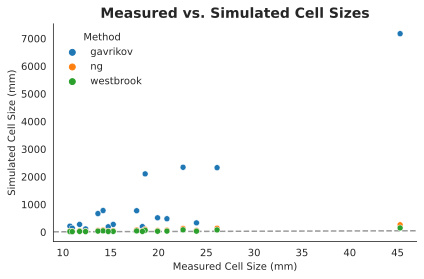

In [8]:
sns.scatterplot(
    x="measured",
    y="cell_size",
    hue="method",
    data=df_plot,
)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim, xlim, "k--", alpha=0.4, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(frameon=False, title="Method")
plt.xlabel("Measured Cell Size (mm)")
plt.ylabel("Simulated Cell Size (mm)")
plt.title("Measured vs. Simulated Cell Sizes", weight="bold", size=14)
plt.tight_layout()
sns.despine()

Remove Gavrikov cell size from the plot due to scale

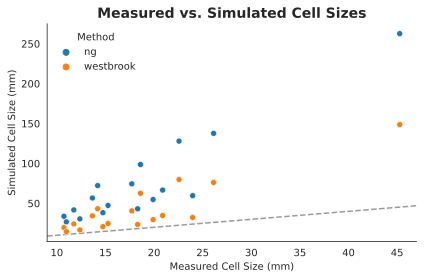

In [9]:
sns.scatterplot(
    x="measured",
    y="cell_size",
    hue="method",
    data=df_plot[df_plot["method"] != "gavrikov"],
)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim, xlim, "k--", alpha=0.4, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(frameon=False, title="Method")
plt.xlabel("Measured Cell Size (mm)")
plt.ylabel("Simulated Cell Size (mm)")
plt.title("Measured vs. Simulated Cell Sizes", weight="bold", size=14)
plt.tight_layout()
sns.despine()

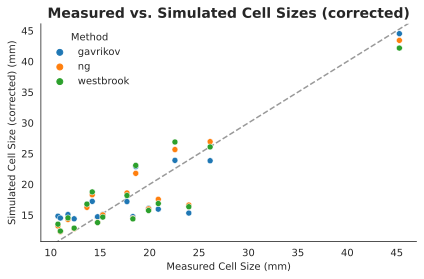

In [10]:
sns.scatterplot(
    x="measured",
    y="cell_size_corrected",
    hue="method",
    data=df_plot,
)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim, xlim, "k--", alpha=0.4, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(frameon=False, title="Method")
plt.xlabel("Measured Cell Size (mm)")
plt.ylabel("Simulated Cell Size (corrected) (mm)")
plt.title("Measured vs. Simulated Cell Sizes (corrected)", weight="bold", size=14)
plt.tight_layout()
sns.despine()

## Regressions

In [11]:
df_regression = pd.DataFrame([{
    "method": m,
    "slope": regressions[m].slope,
    "intercept": regressions[m].intercept,
    "R^2": regressions[m].rvalue**2,
    "p": regressions[m].pvalue,
    "std err": regressions[m].stderr,
} for m in regressions.keys()]).set_index("method", drop=True)

display(Markdown(df_regression.to_markdown()))

| method    |     slope |   intercept |      R^2 |           p |     std err |
|:----------|----------:|------------:|---------:|------------:|------------:|
| gavrikov  | 0.0042673 |    13.9027  | 0.803414 | 1.12144e-06 | 0.000545023 |
| ng        | 0.131985  |     8.7648  | 0.855494 | 1.08513e-07 | 0.014006    |
| westbrook | 0.222057  |     9.16559 | 0.812847 | 7.71646e-07 | 0.0275115   |